In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import Window
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, lag, lead, avg, count, unix_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml.stat import Correlation

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_var_5") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.limit(5).toPandas().head()

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,2016-03-19 10:30:00,16,34,159.990084,1.912269,143.861074,139.368149,139.733305,145.722957,135.563121,...,3.697727,3.697734,3.697740,3.697745,3.697750,3.697755,3.697758,3.809936,3.809939,9.838237
1,2016-03-19 10:45:00,16,34,119.992563,8.295386,134.507290,144.440963,149.232412,131.016820,134.389858,...,3.697873,3.697863,3.697855,3.697848,3.697841,3.697835,3.810004,3.810000,9.838291,12.065509
2,2016-03-19 12:30:00,16,34,111.993059,99.026948,133.860285,138.849683,132.398214,132.391791,135.241348,...,3.810008,9.838298,12.065516,39.849600,50.795950,57.493067,75.089262,127.727624,131.243669,140.617869
3,2016-03-19 14:00:00,16,34,127.992067,183.464305,123.957616,129.463836,139.924336,127.390889,117.757496,...,75.090955,127.729126,131.245003,140.619054,145.892936,148.603865,167.915414,171.953602,186.377286,206.425585
4,2016-03-19 14:15:00,16,34,111.993059,218.446593,127.027236,142.284141,129.150072,115.478574,120.875351,...,127.730441,131.246170,140.620090,145.893856,148.604681,167.916139,171.954246,186.377857,206.426093,214.468607


In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

Столбцы load_XX - показатели прогноза нагрузки потребления за каждые 15 минут, а pv_XX - прогноз произведенного фотоэлектричества на каждые 15 минут

In [4]:
merged_dataframe = merged_dataframe.select('timestamp', 'site_id', 'period_id', 
                                           'actual_consumption', 'actual_pv', 
                                           'load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 
                                           'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95')

In [5]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_19: double (nullable = true)
 |-- load_38: double (nullable = true)
 |-- load_57: double (nullable = true)
 |-- load_76: double (nullable = true)
 |-- load_95: double (nullable = true)
 |-- pv_00: double (nullable = true)
 |-- pv_19: double (nullable = true)
 |-- pv_38: double (nullable = true)
 |-- pv_57: double (nullable = true)
 |-- pv_76: double (nullable = true)
 |-- pv_95: double (nullable = true)



In [6]:
# Вывод количества строк до удаления пустых значений
merged_dataframe.count()

914125

In [7]:
# Вывод количества уникальных значений
merged_dataframe.agg(*(countDistinct(col(c)).alias(c) for c in merged_dataframe.columns)).show()

+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+
|timestamp|site_id|period_id|actual_consumption|actual_pv|load_00|load_19|load_38|load_57|load_76|load_95| pv_00| pv_19| pv_38| pv_57| pv_76| pv_95|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+
|    80621|     15|      115|            192133|   443529| 897295| 903447| 905181| 900598| 886156| 865070|496098|664689|811154|762861|615561|479807|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+



In [8]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

914125

In [9]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.describe()
# Вывод сводной статистики
statistics_summary.toPandas()

,summary,site_id,period_id,actual_consumption,actual_pv,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
0,count,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125
1,mean,22.6049719677287,45.51037987146178,148.91343101832587,112.90172012746065,149.04828691358992,149.51919896078246,149.4332195774401,149.36518484642266,149.32412076445254,149.30465913580645,112.25803487730244,111.77288636425851,111.64791221260056,111.58283482053834,111.50968359476654,111.55458487046262
2,stddev,4.303680898124877,27.32754343962616,88.46807012190563,306.19254238926425,84.76868889863732,76.05515039292106,75.69557039703909,75.67608873283204,75.68886911373875,75.68102799648207,299.47672717751124,289.5818614705614,289.2176343603221,289.05821303507963,288.9725585997834,288.99269427133976
3,min,16,0,0.03365931909114189,0.0,-1457.5318647036945,-616.4660170018908,-214.5262650643704,-54.26426155996367,-26.823037551232947,-26.13249442993074,-794.7447205522094,-598.8022791256082,-372.4889114393399,-85.368085170773,-58.19211334116961,-40.82480334469958
4,max,30,114,3193.2644229865437,4102.021236361368,2469.256235423116,1862.6448746530268,1874.5674756473,1879.4655093135716,1880.9033354309413,1882.01744291954,4644.918647598194,3910.3960141431385,3807.653648685541,3807.6530105626516,3807.653001801597,3807.6530044049787


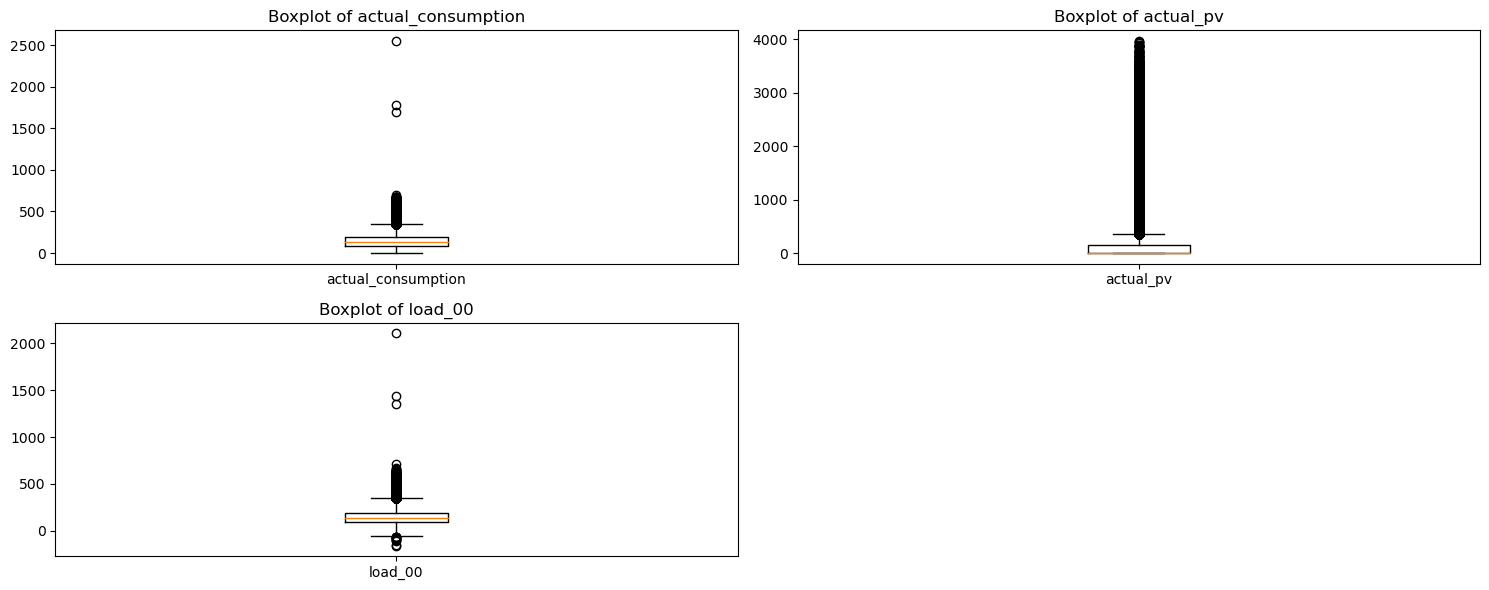

In [10]:
def print_columns_box_plots(dataframe, columns_to_print, sample_fraction=0.1, number_of_cols=2):
    # Определение количества строк и столбцов для Subplots
    num_rows = len(columns_to_print) // number_of_cols + (len(columns_to_print) % number_of_cols > 0)
    
    # Сэмплируем и преобразуем PySpark DataFrame в Pandas DataFrame
    sampled_pandas_df = dataframe.select(columns_to_print).sample(fraction=sample_fraction, seed=42).toPandas()
    
    fig, axs = plt.subplots(num_rows, number_of_cols, figsize=(15, 3 * num_rows))
    
    for i, column in enumerate(columns_to_print):
        # Построение boxplot
        axs[i // number_of_cols, i % number_of_cols].boxplot(sampled_pandas_df[column], labels=[column])
        axs[i // number_of_cols, i % number_of_cols].set_title(f'Boxplot of {column}')
    
    # Убираем пустые подграфики, если количество не кратно number_of_cols
    for i in range(len(columns_to_print), num_rows * number_of_cols):
        fig.delaxes(axs.flatten()[i])
    
    # Регулировка расположения подграфиков
    plt.tight_layout()
    
    # Отображение графика
    plt.show()


# Список столбцов для обработки
columns_to_filter = ['actual_consumption', 'actual_pv', 'load_00']
print_columns_box_plots(cleaned_dataframe, columns_to_filter)

In [14]:
# Фильтрация выбросов для каждого столбца
for column in columns_to_filter:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR
    
    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_before = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_before = cleaned_dataframe.filter(col(column) > upper_bound).count()
    
    print(f"Количество выбросов ДО фильтрации у '{column}': Снизу: {below_quartile_count_before}, Сверху: {above_quartile_count_before}")
    
    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_after = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_after = cleaned_dataframe.filter(col(column) > upper_bound).count()
    
    print(f"Количество выбросов ПОСЛЕ фильтрации у '{column}': Снизу: {below_quartile_count_after}, Сверху: {above_quartile_count_after}")

    # Рассчет максимального и минимального значения после фильтрации
    max_value_after = cleaned_dataframe.agg(functions.max(col(column))).collect()[0][0]
    min_value_after = cleaned_dataframe.agg(functions.min(col(column))).collect()[0][0]
    
    #Расчет медианы после фильтрации
    median_value_after = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    
    print(f"После фильтрации у '{column}': Максимальное значение: {max_value_after}, Минимальное значение: {min_value_after}, Медиана: {median_value_after}")

Количество выбросов ДО фильтрации у 'actual_consumption': Снизу: 0, Сверху: 3055
Количество выбросов ПОСЛЕ фильтрации у 'actual_consumption': Снизу: 0, Сверху: 0
После фильтрации у 'actual_consumption': Максимальное значение: 313.03166754761963, Минимальное значение: 0.03365931909114189, Медиана: 124.35949929952167
Количество выбросов ДО фильтрации у 'actual_pv': Снизу: 0, Сверху: 109271
Количество выбросов ПОСЛЕ фильтрации у 'actual_pv': Снизу: 0, Сверху: 0
После фильтрации у 'actual_pv': Максимальное значение: 103.81436951271299, Минимальное значение: 0.0, Медиана: 0.0
Количество выбросов ДО фильтрации у 'load_00': Снизу: 51, Сверху: 9002
Количество выбросов ПОСЛЕ фильтрации у 'load_00': Снизу: 0, Сверху: 0
После фильтрации у 'load_00': Максимальное значение: 289.52072878102155, Минимальное значение: -37.18756789984633, Медиана: 119.04648873235509


Гистограммы распределения количественных признаков

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

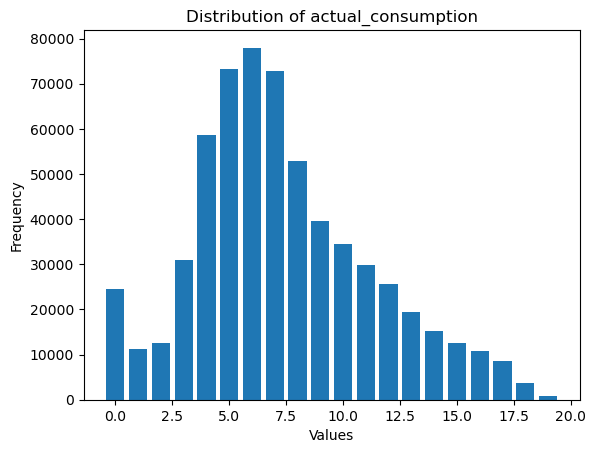

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

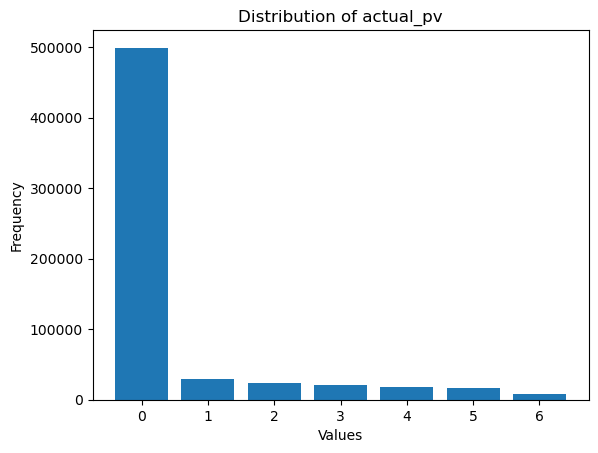

<BarContainer object of 19 artists>

Text(0.5, 1.0, 'Distribution of load_00')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

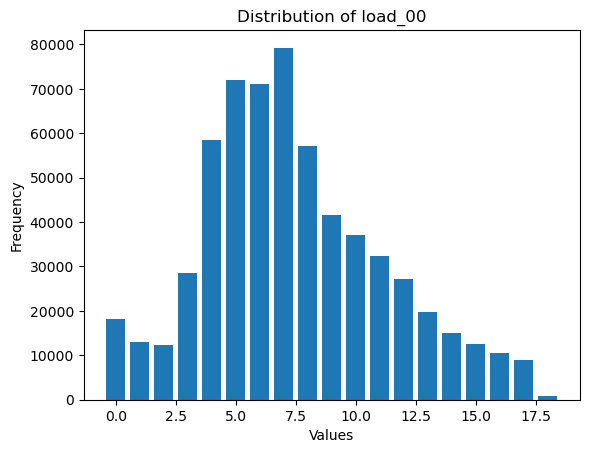

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of load_95')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

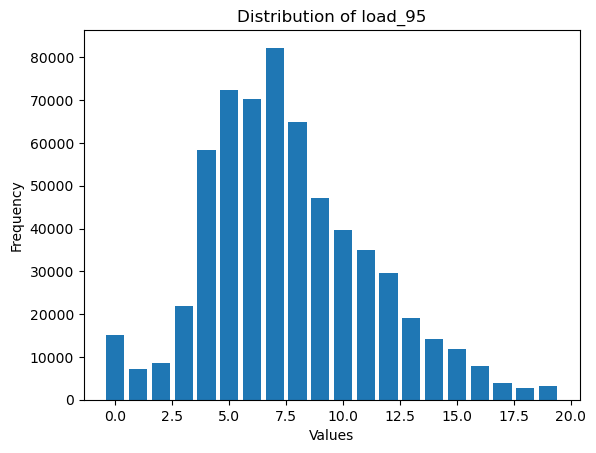

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of pv_00')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

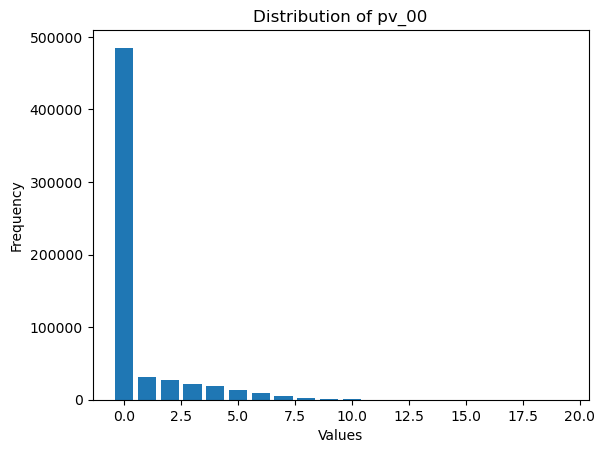

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of pv_95')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

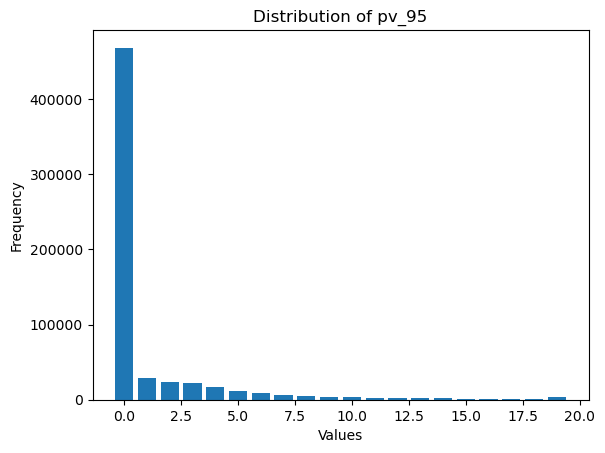

In [15]:
selected_features = ['actual_consumption', 'actual_pv', 'load_00', 'load_95', 'pv_00', 'pv_95'] 

num_buckets = 20
step = 320 / num_buckets
splits = [float("-inf")] + [i * step for i in range(1, num_buckets)] + [float("inf")]
# Построение гистограммы для каждой колонки
for selected_column in selected_features:
    bucketizer = Bucketizer(splits=splits, inputCol=selected_column, outputCol="bucketizer")
    df_bucket = bucketizer.transform(cleaned_dataframe)
    bucket_counts = df_bucket.groupBy("bucketizer").count().orderBy("bucketizer")
    bucket_counts_pd = bucket_counts.toPandas()
    plt.bar(bucket_counts_pd["bucketizer"], bucket_counts_pd["count"], align="center", label=selected_column)
    plt.title(f"Distribution of {selected_column}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

Гистограммы распределения категориальных признаков

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'Distribution of site_id')

Text(0.5, 0, 'site_id')

Text(0, 0.5, 'Count')

<BarContainer object of 115 artists>

Text(0.5, 1.0, 'Distribution of period_id')

Text(0.5, 0, 'period_id')

Text(0, 0.5, 'Count')

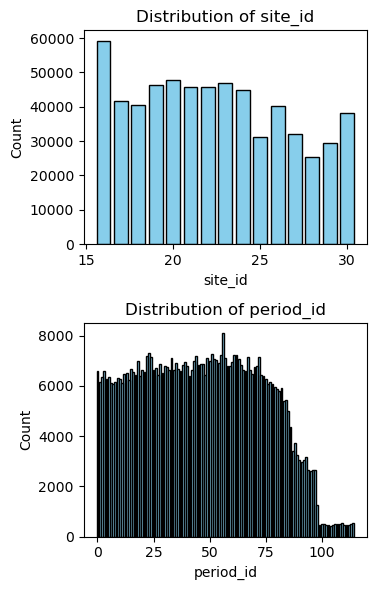

In [16]:
selected_features = ['site_id', 'period_id'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [17]:
# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

In [18]:
correlation_df.corr()

,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
load_00,1.000000,0.472703,0.171821,0.341047,0.688942,0.969637,0.152565,-0.413216,-0.669249,-0.569219,-0.238727,0.099272
load_19,0.472703,1.000000,0.743635,0.241812,0.140481,0.448109,-0.049474,0.254243,-0.002112,-0.638763,-0.705494,-0.190357
load_38,0.171821,0.743635,1.000000,0.623706,0.256517,0.179341,-0.447964,0.053569,0.213750,-0.167683,-0.540021,-0.536923
load_57,0.341047,0.241812,0.623706,1.000000,0.800242,0.403933,-0.621315,-0.534683,-0.225308,0.144200,0.059694,-0.580749
load_76,0.688942,0.140481,0.256517,0.800242,1.000000,0.759093,-0.291601,-0.690711,-0.609655,-0.104093,0.122347,-0.235579
load_95,0.969637,0.448109,0.179341,0.403933,0.759093,1.000000,0.135768,-0.454704,-0.698947,-0.559454,-0.215410,0.096501
pv_00,0.152565,-0.049474,-0.447964,-0.621315,-0.291601,0.135768,1.000000,0.077968,-0.414543,-0.570694,-0.227820,0.894145
pv_19,-0.413216,0.254243,0.053569,-0.534683,-0.690711,-0.454704,0.077968,1.000000,0.678986,-0.284305,-0.527903,-0.076451
pv_38,-0.669249,-0.002112,0.213750,-0.225308,-0.609655,-0.698947,-0.414543,0.678986,1.000000,0.346684,-0.286150,-0.470233
pv_57,-0.569219,-0.638763,-0.167683,0.144200,-0.104093,-0.559454,-0.570694,-0.284305,0.346684,1.000000,0.679036,-0.451704


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

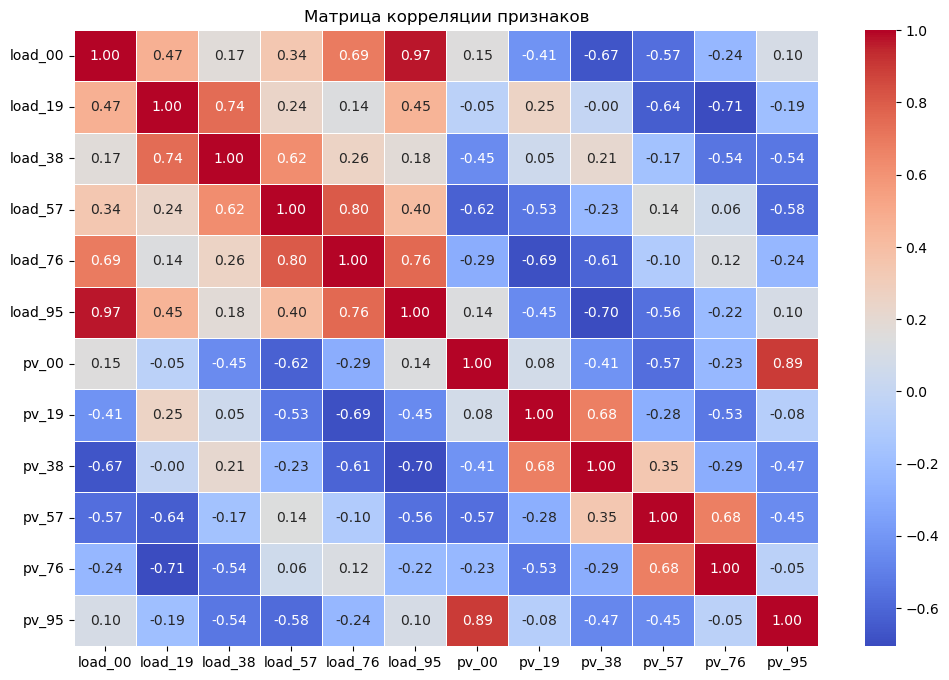

In [19]:
# Строим тепловую карту корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [20]:
# Сохраним преобразованный датафрейм в csv-файл.
cleaned_dataframe.coalesce(1).write.mode('overwrite').options(header='True', delimiter=';').csv('filtered_data/data')
# Закрываем сессию Spark
spark.stop()